# 用ES搜尋2016前半年，遠傳中華台哥大的粉絲專頁
# 並算出包含（按讚/分享/留言/抽獎）文章的比例 以及 包含（方案）的比例

In [124]:
%matplotlib inline

import pyes
import json
import pandas as pd
import seaborn as sns

# import sys  

# reload(sys)  
# sys.setdefaultencoding('utf8')


#get post with higher like and share count
def higherLike(fids,host):
#     print "123"
    imgData = []
    names = []
    percentage=[];
    p2 = [];
    for fid in fids:
        like=[];
        share=[];
        comment=[];
        both=[];
        project=[];
        conn = pyes.es.ES(host)
        
        bq = pyes.query.BoolQuery() 
        tq = pyes.query.TermQuery(field="fid", value=fid)
        time = pyes.ESRange(field="created_time", from_value="2016-01-01T06:30:44+0000", to_value="2016-05-31T06:30:44+0000", include_lower=True ,include_upper=False)
        timeq = pyes.query.RangeQuery(time)
#         tagg = pyes.aggs.TermsAgg('pid', field= 'id')
        bq.add_must(tq)
        bq.add_must(timeq)
        qsearch = pyes.query.Search(bq) 
#         qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='post', sort="likes_count:desc,comment_count:desc", size=100)
#         print json.dumps(result.aggs,indent=2)
#         print json.dumps(result[0],indent=2)
        print result[0].fname
        names.append(result[0].fname)
        for r in result:
#             print r.message
#             print "-----"
            try:
#                 if unicode("按讚","utf-8") in r.message:
#                     like.append(r)
#                 if unicode("分享","utf-8") in r.message:
#                     share.append(r)
#                 if unicode("留言","utf-8") in r.message:
#                     comment.append(r)
                if unicode("按讚","utf-8") in r.message or unicode("分享","utf-8") in r.message or unicode("留言","utf-8") in r.message and unicode("抽","utf-8") in r.message:
                    both.append(r.fid)
                    imgData.append(r.fid)
                if unicode("方案","utf-8") in r.message:
                    project.append(r.fid)
            except:
                continue
#         print len(like)
#         print len(share)
#         print len(comment)
#         print len(both)
        percentage.append(float(len(both))/float(100))
        p2.append(float(len(project))/float(100))
    print "抽獎"
    for p in percentage:
        print p
    print "方案"
    for p in p2:
        print p
    df = pd.DataFrame
    (
        {
            "name": imgData
        }
    )
    sns.countplot(imgData)
#     sns.plt.show()

# 設定參數來執行剛剛上面的function


遠傳電信
中華電信行動學園
台灣大哥大與你生活在一起
抽獎
0.43
0.17
0.07
方案
0.1
0.23
0.03


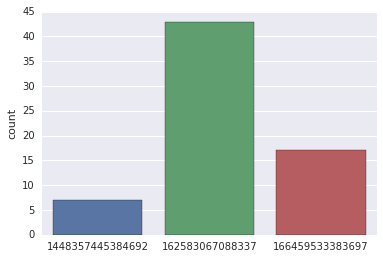

In [125]:
#assign the facebook fans page that you prefered
fids=['162583067088337','166459533383697','1448357445384692']

#遠傳 中華 台哥大
#elasticsearch repository provided by this course
host = '140.118.126.237:9200'

higherLike(fids,host)

# 明顯看出台灣大哥大這兩系列文章較少，為何呢～～

In [126]:
def boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter):
    data=[]
    for fid in fids:
        conn = pyes.es.ES(host)
        tq = pyes.query.TermQuery(field="fid", value=fid)
        tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
        #print json.dumps(result.aggs,indent=2) 
        for fidpid_summary in result.aggs["pid"]["buckets"]:
            #print fidpid_summary["key"] + ',' + str(fidpid_summary["doc_count"])
            if fidpid_summary["doc_count"] < outlierFilter or outlierFilter < 0:
                data.append([fidpid_summary["doc_count"],fid,fidpid_summary["key"]])

    df=pd.DataFrame(data,columns={'count','fid','fidpid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="fid", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    fig.savefig(pngFilePath)

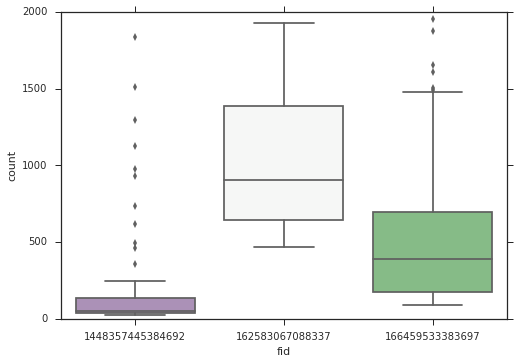

In [127]:
pngFilePath="output.png"

outlierFilter=2000

boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter)

## 可以看出台灣大哥大的讚數分佈跟其他家有毀滅性的差異
## 既不推廣新方案，也不抽獎 應該是他們沒什麼讚的原因之一